In [6]:
using Fretem, Potential, Alphabeta, PyPlot, Printf, JLD

┌ Info: Precompiling JLD [4138dd39-2aa7-5051-a626-17a0bb65d9c8]
└ @ Base loading.jl:1260


### Part 0: Get collocation points and integration kernel for whole domain

In [7]:
Nh = 64    # The number of Spectral element
Np = 4     # The order of polynomial which used to interpolate and integration

# Define Physical Domain
xratio = 0.5
xavg = 1.0

x, w, Ldx, L = getLagrange(Np,xratio/Nh)
e_norm = x[end] - x[1]
interpo_xs = x .+ x[end]

N, xref, w0, Ldx, w = get_fem_xref_weights_basis(Nh, Np, xratio, xavg);

### Part 1: Set $V(x)$ and $p_{eq}(x)$ for simulation

In [37]:
k_ref = 247.15 # 247.15
Vref = harmonic_well(xref, k_ref)
rho_eq = get_rhoeq(Vref, w0);

In [38]:
# physical parameters
tau = 30000  # Number of photons
dt = 1e-3 # 10^(-9)s
kbT = 1
D = 1e-1; # Diffusion coefficient, unit: s-1

### Part 2: Simulation

In [39]:
# Simulation
y_record = zeros(tau+1, 1)  # In HMM, observing variables Y(t)
t_record = zeros(tau+1, 1)

ypos = 1 # Initial Position
t = 0
y_record[1] = ypos
t_record[1] = t

# Simulation Start
for i = 2:tau+1
    F = force_harmonic_well(ypos, k_ref)
    ypos = ypos + D*dt*F +  (dt*2*kbT*D)^(1/2) * randn()
    t += dt
    y_record[i] = ypos
    t_record[i] = t
end

In [23]:
# Save simulated trajectory to jld file
f_out = "../trajectory/30000_photons_harmonic_well.jld"
save(f_out, "y_record", y_record, "t_record", t_record, "xref", xref, "rho_eq", rho_eq, "D", D, "k_ref", k_ref)

In [24]:
# Read simulated trajectory from jld file
f_in = "../trajectory/30000_photons_harmonic_well.jld"
y_record = load(f_in, "y_record")
t_record = load(f_in, "t_record")
xref = load(f_in, "xref")
rho_eq = load(f_in, "rho_eq")
k_ref = load(f_in, "k_ref")
D = load(f_in, "D");

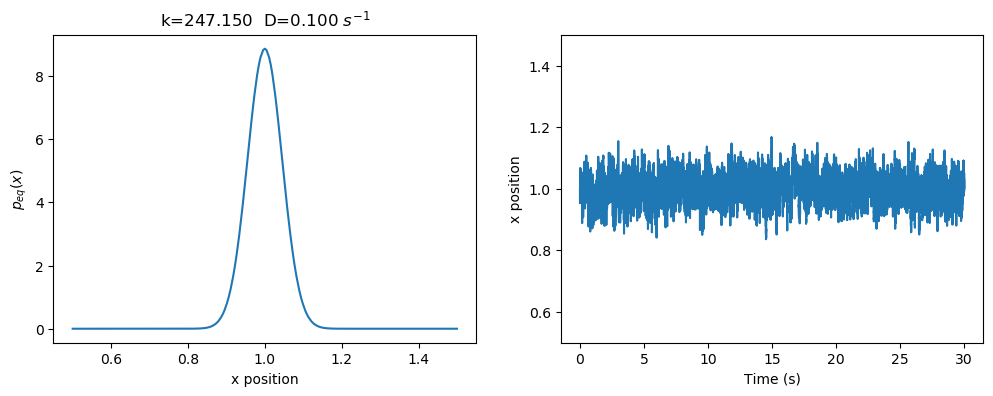

In [48]:
# Plot
fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(12,4))

ax = axes[1]
ax.plot(xref, rho_eq .* rho_eq)
ax.set_xlabel("x position")
ax.set_ylabel("\$ p_{eq}(x) \$")
title = @sprintf "k=%.3f  D=%.3f \$s^{-1}\$" k_ref D
ax.set_title(title)

ax = axes[2]
ax.plot(t_record, y_record)
ax.set_ylim(0.5, 1.5)
ax.set_xlabel("Time (s)")
ax.set_ylabel("x position")
#plt.savefig("Simu_for_EM.png", dpi=200)
plt.show()

### Part 3: Initial guess $p^0_{eq}(x)$

In [41]:
k = 150 # 247.15
V = harmonic_well(xref, k)
rho = get_rhoeq(V, w0)
p = rho .* rho
Nv = 36; # Number of eigenvectors

### Part 4: Four times forward-backward

In [42]:
p_em_1 = forward_backward(Nh, Np, xratio, xavg, p, D, Nv, tau, y_record, dt)
p_em_1 = max.(p_em_1, 1e-10);

In [43]:
p_em_2 = forward_backward(Nh, Np, xratio, xavg, p_em_1, D, Nv, tau, y_record, dt)
p_em_2 = max.(p_em_2, 1e-10);

In [44]:
p_em_3 = forward_backward(Nh, Np, xratio, xavg, p_em_2, D, Nv, tau, y_record, dt)
p_em_3 = max.(p_em_3, 1e-10);

In [45]:
p_em_4 = forward_backward(Nh, Np, xratio, xavg, p_em_3, D, Nv, tau, y_record, dt)
p_em_4 = max.(p_em_4, 1e-10);

### Part 5: Plot EM results

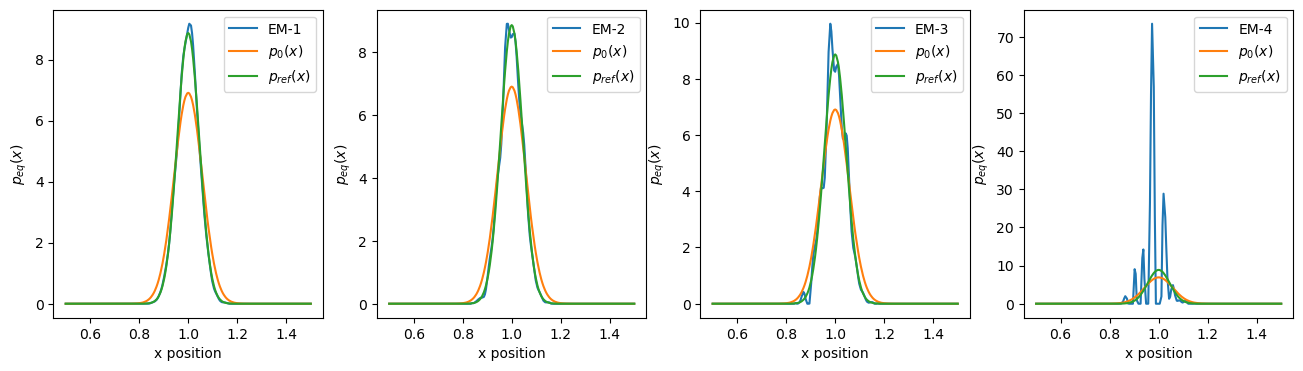

In [47]:
fig, axes = plt.subplots(ncols=4, nrows=1, figsize=(16, 4))

ax = axes[1]
ax.plot(xref, p_em_1, label="EM-1")
ax.plot(xref, rho .* rho, label="\$ p_0(x) \$")
ax.plot(xref, rho_eq .* rho_eq, label="\$ p_{ref}(x) \$")
ax.legend()
ax.set_xlabel("x position")
ax.set_ylabel("\$ p_{eq}(x) \$")

ax = axes[2]
ax.plot(xref, p_em_2, label="EM-2")
ax.plot(xref, rho .* rho, label="\$ p_0(x) \$")
ax.plot(xref, rho_eq .* rho_eq, label="\$ p_{ref}(x) \$")
ax.legend()
ax.set_xlabel("x position")
ax.set_ylabel("\$ p_{eq}(x) \$")

ax = axes[3]
ax.plot(xref, p_em_3, label="EM-3")
ax.plot(xref, rho .* rho, label="\$ p_0(x) \$")
ax.plot(xref, rho_eq .* rho_eq, label="\$ p_{ref}(x) \$")
ax.legend()
ax.set_xlabel("x position")
ax.set_ylabel("\$ p_{eq}(x) \$")

ax = axes[4]
ax.plot(xref, p_em_4, label="EM-4")
ax.plot(xref, rho .* rho, label="\$ p_0(x) \$")
ax.plot(xref, rho_eq .* rho_eq, label="\$ p_{ref}(x) \$")
ax.legend()
ax.set_xlabel("x position")
ax.set_ylabel("\$ p_{eq}(x) \$")

#plt.savefig("EM_test_1to4.png", dpi=200)
plt.show()